In [48]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd

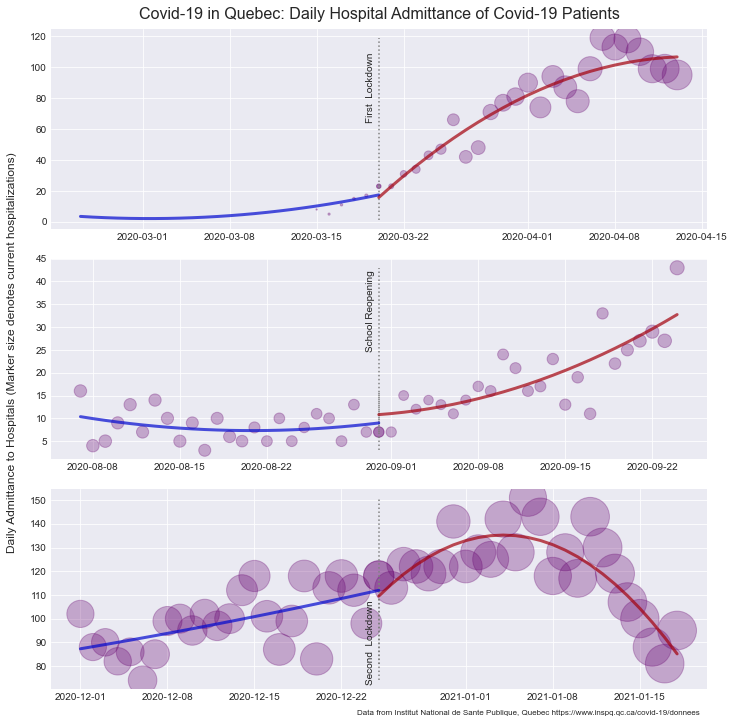

In [49]:
total_df = pd.read_csv(r'RDD-Regression-on-Covid-19-Hospitalizations-in-Quebec\Graphique 3.1 - page_principal.csv')
daily_df = pd.read_csv(r'RDD-Regression-on-Covid-19-Hospitalizations-in-Quebec\Graphique 3.2 - page_principal.csv')
#Datasets found here: https://www.inspq.qc.ca/covid-19/donnees 

#Rework some data.
total_df = total_df.fillna(0)
total_df['total'] = total_df['Hors soins intensifs (nouvelle définition)'] + total_df['Hors soins intensifs (ancienne définition)'] + total_df['Aux soins intensifs']
daily_df['numtoday'] = daily_df['Hors soins intensifs'] + daily_df['Aux soins intensifs'] 

#Merge the sets.
df_ = daily_df.merge(total_df, how='left', left_on="Date d'admission", right_on="DateTime")

#Set our event times.
first_lockdown = pd.to_datetime("2020-03-20 00:00:00")
second_lockdown = pd.to_datetime("2020-12-25 00:00:00")
school_opening = pd.to_datetime("2020-08-31 00:00:00")

#Make a simple looping function so we can replicate this.
def rdd_plot(time, ax, before):
    df = df_
    df['date'] = pd.to_datetime(df["Date d'admission"])
    
    if before:
        temp_df = df.loc[( df.date > (time - pd.Timedelta(days=25) )) & ( df.date <= time )]
        colour = '#0008cf'
    else:
        temp_df = df.loc[( df.date < (time + pd.Timedelta(days=25) )) & ( df.date >= time )]
        colour = '#a3000c'

    temp_df['day_count'] = range(1, (len(temp_df.index)+1))
    y = temp_df[['numtoday']]
    x = temp_df[['day_count']] 
    X = sm.add_constant(x)
    X['day_count_sqr'] = X['day_count']**2

    model = sm.OLS(y, X).fit(cov_type='HC2')
    yfit = model.predict(X)

    return ax.scatter(temp_df.date, temp_df.numtoday, color='#680672', alpha=0.3, s=(temp_df.total)), ax.plot(temp_df.date, yfit, color=colour, alpha=0.7, linewidth=3), ax.vlines(time, ymin = temp_df.numtoday.min(), ymax = temp_df.numtoday.max(), color='grey', ls ='dotted'), model


#Set the subplots and run our functions (Yes, I know its sloppy, I hate looking at this)
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(10, 10))

lock1_before = rdd_plot(first_lockdown, ax1, True)
lock1_after = rdd_plot(first_lockdown, ax1, False)
ax1.text(y=65, x=first_lockdown - pd.Timedelta(days=1), s= 'First  Lockdown', rotation=90)

sch_before = rdd_plot(school_opening, ax2, True)
sch_after = rdd_plot(school_opening, ax2, False)
ax2.text(y=25, x=school_opening - pd.Timedelta(days=1), s= 'School Reopening', rotation=90)

lock2_before = rdd_plot(second_lockdown, ax3, True)
lock2_after = rdd_plot(second_lockdown, ax3, False)
ax3.text(y=73, x=second_lockdown - pd.Timedelta(days=1), s= 'Second  Lockdown', rotation=90)

# Why are we doing this if not for cool aesthetics?
fig.suptitle("Covid-19 in Quebec: Daily Hospital Admittance of Covid-19 Patients", size=16)
plt.style.use(['seaborn-darkgrid'])
fig.tight_layout()
fig.subplots_adjust(top=0.95)
fig.text(-0.01, 0.5,'Daily Admittance to Hospitals (Marker size denotes current hospitalizations)', ha='center', va='center', rotation='vertical', size=12)
plt.annotate('Data from Institut National de Sante Publique, Quebec https://www.inspq.qc.ca/covid-19/donnees', (1,0), (-350,-20), fontsize=8, 
        xycoords='axes fraction', textcoords='offset points', va='top')
plt.show()


In [122]:
#Uncomment to view regression models.

# print(lock1_before[3].summary())
# print(lock1_after[3].summary())
# print(sch_after[3].summary())
# print(sch_before[3].summary())
# print(lock2_before[3].summary())
# print(lock2_after[3].summary())